In [2]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from typing import Tuple
%matplotlib notebook

from KalmanFilterModel import *

## To do
1. update matrix multiplication to @
2. typing
3. docstring
4. exception using assert
5. convert to classes

## Refactor code for Kalman Filter

In [ ]:
def covars(F: np.ndarray, G:np.ndarray, H:np.ndarray, Q:np.ndarray, R:np.ndarray, P0:np.ndarray, t_steps:int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    A function to compute gain and covariance history for a Kalman Filter
    
    Args:
        F (numpy.ndarray):  Xsize*Xsize state transition matrix
        G (numpy.ndarray):  Xsize*Vsize state noise transition matrix
        H (numpy.ndarray):  Zsize*Xsize observation matrix
        Q (numpy.ndarray):  Vsize*Vsize process noise covariance matrix
        R (numpy.ndarray):  Zsize*Zsize observation noise covariance matrix
        P0 (numpy.ndarray): Xsize*Xsize initial state covariance
        t_steps (int):      number of time-steps to be simulated
        
    Returns:
        X (numpy.ndarray):     t_steps*(Xsize*Zsize): Gain history
        Pest (numpy.ndarray):  t_steps*(Xsize*Xsize): Estimate Covariance history
        Ppred (numpy.ndarray): t_steps*(Xsize*Xsize): Prediction Covariance history
        S (numpy.ndarray):     t_steps*(Xsize*Xsize): Innovation Covariance history
    ''' 

    # First check all matrix dimensions
    assert P0.shape[0] == P0.shape[1], 'P0 is non-square'
    assert F.shape[0] == F.shape[1], 'F is non-square'
    assert P0.shape[0] == F.shape[0], 'P0 does not match dimension of F'
    assert G.shape[0] == x0.shape[0], 'G does not match dimension of xo or F'
    assert Q.shape[0] == Q.shape[1], 'Q must be square'
    assert Q.shape[0] == G.shape[1], 'Q does not match dimension of G'
    assert H.shape[1] == x0.shape[0], 'H and Xsize do not match'
    assert R.shape[0] == R.shape[1], 'R must be square'      
    assert R.shape[0] == H.shape[0], 'R must match Zsize of H'

    # define a few parameters for output matrix dimension specification
    Xsize = P0.shape[0]
    Zsize = H.shape[0]
    
   # fix up output matricies
    W = np.zeros((t_steps, Xsize * Zsize))
    Pest = np.zeros((t_steps, Xsize * Xsize))
    Ppred = np.zeros((t_steps, Xsize * Xsize))
    S = np.zeros((t_steps, Zsize * Zsize))
    
    # initial value
    lPest = P0
    
   # ready to go !
    for i in range(1, t_steps): 
        # first the actual calculation in local variables
        lPpred = F @ lPest @ F.T + G @ Q @ G.T
        lS = H @ lPpred @ H.T + R
        lW = lPpred @ H.T @ np.linalg.inv(lS) 
        lPest = lPpred - lW @ lS @ lW.T
        # then record the results in columns of output states
        Pest[i, :] = lPest.reshape(1, Xsize*Xsize)
        Ppred[i, :] = lPpred.reshape(1, Xsize*Xsize)
        W[i, :] = lW.reshape(1, Xsize*Zsize)
        S[i, :]= lS.reshape(1, Zsize*Zsize)
        
    return W, Pest, Ppred, S

In [ ]:
def xestim(F: np.ndarray, G:np.ndarray, H:np.ndarray, Q:np.ndarray, R:np.ndarray, x0:np.ndarray, P0:np.ndarray, z:np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    A basic linear Kalman filter. Calls COVARS for gain history.
    
    Args:
        F (numpy.ndarray):  Xsize*Xsize state transition matrix
        G (numpy.ndarray):  Xsize*Vsize state noise transition matrix
        H (numpy.ndarray):  Zsize*Xsize observation matrix
        Q (numpy.ndarray):  Vsize*Vsize process noise covariance matrix
        R (numpy.ndarray):  Zsize*Zsize observation noise covariance matrix
        x0 (numpy.ndarray): Xsize*1 initial state vector 
        P0 (numpy.ndarray): Xsize*Xsize initial state covariance
        z (numpy.ndarray):  Zsize*t_steps observation sequence to be filtered
        
    Returns:
        xest (numpy.ndarray):  Xsize*t_steps estimated state time history
        xpred (numpy.ndarray): Xsize*t_steps predicted state time history
        innov (numpy.ndarray): Zsize*t_steps innovation time history
    ''' 

    # First check all matrix dimensions
    assert F.shape[0] == F.shape[1], 'F is non-square'
    assert x0.shape[0] == F.shape[0], 'x0 does not match dimension of F'
    assert G.shape[0] == x0.shape[0], 'G does not match dimension of xo or F'
    assert Q.shape[0] == Q.shape[1], 'Q must be square'
    assert Q.shape[0] == G.shape[1], 'Q does not match dimension of G'
    assert H.shape[1] == x0.shape[0], 'H and Xsize do not match'
    assert R.shape[0] == R.shape[1], 'R must be square'      
    assert R.shape[0] == H.shape[0], 'R must match Zsize of H'
    assert P0.shape[0] == P0.shape[1], 'P0 is non-square'
    assert P0.shape[0] == x0.shape[0], 'P0 must have dimensions of x0 (Xsize)'
    assert z.shape[0] == H.shape[0], 'Observation Sequence must have Zsize rows'
        
    # define a few parameters for output matrix dimension specification
    Xsize = P0.shape[0]
    Zsize = H.shape[0]
    t_steps = z.shape[1]
    
    # fix up output matricies
    xest = np.zeros((Xsize, t_steps))
    xpred = np.zeros((Xsize, t_steps))
    innov = np.zeros((Zsize, t_steps))
    
   # compute all the neccesary gain matricies a priori
    W = covars(F,G,H,Q,R,P0,t_steps)[0]
    
    # initial prediction and estimate (done seperately because of X0)
    lW = W[1,:].reshape(Xsize,Zsize)
    xpred[:,1, None] = F @ x0
    innov[:,1, None] = z[:,1] - H @ xpred[:,1]
    xest[:,1] = xpred[:,1] + lW @ innov[:,1]
    
    # now generate all the remaining estimates
    for i in range(2, t_steps):
        xpred[:,i] = F @ xest[:,i-1]
        innov[:,i] = z[:,i] - H @ xpred[:,i]
        lW = W[i,:].reshape(Xsize,Zsize)
        xest[:,i] = xpred[:,i] + lW @ innov[:,i]
        
    return xest,xpred,innov

In [3]:
# observation model
H = np.array([[1, 0]])

# continuous time noise variance, must be square
Q = np.array([[0.01]]) 

# observation noise variance, must be square
R = np.array([[1]])

# initial conditions
x0 = np.array([[0]
            ,[0]])

# sample period
dt = 1.0

# number of time-steps to simulate
t_steps = 500

time = range(t_steps+1)

#Transform a continuous to a discrete state-space system.
F = np.array([[1, dt]
            , [0, 1]])

G = np.array([[dt**2/2]
            , [dt]])

# assumes run_sim has been run at least once
Q = Q * 10
R = R * 10

#initial covariance required, P0 has to be of the same dimension as F
P0 = np.ones((2,2)) * 10 * Q 
x0 = np.array([[0]
             , [0]])

In [4]:
simulate_dta = Simulate(F, G, H, Q, R, x0, t_steps)
print(simulate_dta)
z, x = simulate_dta.simulate()

Simulate data.


<IPython.core.display.Javascript object>


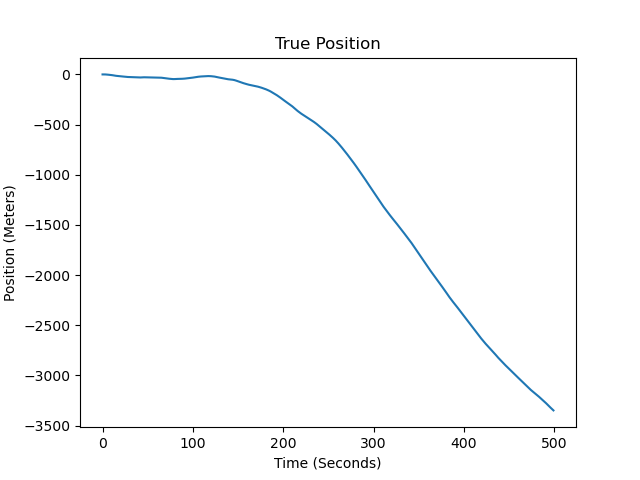

In [5]:
simulate_dta.plot_TruePos(x)

In [ ]:
W, Pest, Ppred, S = covars(F,G,H,Q,R,P0,t_steps)

In [ ]:
xest, xpred, xinnov = xestim(F,G,H,Q,R,x0,P0,z)

## Class implementation

In [6]:
class KalmanFilter(Diagnostics_plots):
    '''A basic linear Kalman filter. Calls COVARS for gain history.'''
    
    def __init__(self, F_init, G_init, H_init, Q_init, R_init, P0_init, x0_init, t_steps_init, z_init):
        '''
        Initialise the class
        Args:
            F (numpy.ndarray):  Xsize*Xsize state transition matrix
            G (numpy.ndarray):  Xsize*Vsize state noise transition matrix
            H (numpy.ndarray):  Zsize*Xsize observation matrix
            Q (numpy.ndarray):  Vsize*Vsize process noise covariance matrix
            R (numpy.ndarray):  Zsize*Zsize observation noise covariance matrix
            P0 (numpy.ndarray): Xsize*Xsize initial state covariance
            x0 (numpy.ndarray): Xsize*1 initial state vector 
            t_steps (int):      number of time-steps to be simulated  
            z (numpy.ndarray):  Zsize*t_steps observation sequence to be filtered

        Returns:
            X (numpy.ndarray):     t_steps*(Xsize*Zsize): Gain history
            Pest (numpy.ndarray):  t_steps*(Xsize*Xsize): Estimate Covariance history
            Ppred (numpy.ndarray): t_steps*(Xsize*Xsize): Prediction Covariance history
            S (numpy.ndarray):     t_steps*(Xsize*Xsize): Innovation Covariance history
            
            xest (numpy.ndarray):  Xsize*t_steps estimated state time history
            xpred (numpy.ndarray): Xsize*t_steps predicted state time history
            innov (numpy.ndarray): Zsize*t_steps innovation time history
        '''
        self.F = F_init
        self.G = G_init
        self.H = H_init
        self.Q = Q_init
        self.R = R_init
        self.P0 = P0_init
        self.x0 = x0_init
        self.t_steps = t_steps_init    
        self.z = z_init
    
    def _validate_data(self):
        '''Validate input data.'''
        assert self.P0.shape[0] == self.P0.shape[1], 'P0 is non-square'
        assert self.F.shape[0] == self.F.shape[1], 'F is non-square'
        assert self.x0.shape[0] == self.F.shape[0], 'x0 does not match dimension of F'
        assert self.P0.shape[0] == self.F.shape[0], 'P0 does not match dimension of F'
        assert self.G.shape[0] == self.x0.shape[0], 'G does not match dimension of xo or F'
        assert self.Q.shape[0] == self.Q.shape[1], 'Q must be square'
        assert self.Q.shape[0] == self.G.shape[1], 'Q does not match dimension of G'
        assert self.H.shape[1] == self.x0.shape[0], 'H and Xsize do not match'
        assert self.R.shape[0] == self.R.shape[1], 'R must be square'      
        assert self.R.shape[0] == self.H.shape[0], 'R must match Zsize of H'
        assert self.P0.shape[0] == self.x0.shape[0], 'P0 must have dimensions of x0 (Xsize)'
        assert self.z.shape[0] == self.H.shape[0], 'Observation Sequence must have Zsize rows'
        return self.F, self.G, self.H, self.Q, self.R, self.P0, self.x0, self.z
    
    def _covars(self):
        '''Compute gain and covariance history for a Kalman Filter'''
        # validate data first
        F, G, H, Q, R, P0, x0, z = self._validate_data()
        
        # define a few parameters for output matrix dimension specification
        Xsize = P0.shape[0]
        Zsize = H.shape[0]
        
        # fix up output matricies
        W = np.zeros((self.t_steps, Xsize * Zsize))
        Pest = np.zeros((self.t_steps, Xsize * Xsize))
        Ppred = np.zeros((self.t_steps, Xsize * Xsize))
        S = np.zeros((self.t_steps, Zsize * Zsize))
        
        # initial value
        lPest = P0
        
        # ready to go !
        for i in range(self.t_steps-1): 
            # first the actual calculation in local variables
            lPpred = F @ lPest @ F.T + G @ Q @ G.T
            lS = H @ lPpred @ H.T + R
            lW = lPpred @ H.T @ np.linalg.inv(lS) 
            lPest = lPpred - lW @ lS @ lW.T
            # then record the results in columns of output states
            Pest[i+1, :] = lPest.reshape(1, Xsize*Xsize)
            Ppred[i+1, :] = lPpred.reshape(1, Xsize*Xsize)
            W[i+1, :] = lW.reshape(1, Xsize*Zsize)
            S[i+1, :]= lS.reshape(1, Zsize*Zsize)

        return W, Pest, Ppred, S
        
    def xestim(self):
        '''Estimate linear kalman filter. calls _covars for gain history.'''
        # validate data first
        F, G, H, Q, R, P0, x0, z = self._validate_data()
        
        # define a few parameters for output matrix dimension specification
        Xsize = P0.shape[0]
        Zsize = H.shape[0]

        # fix up output matricies
        xest = np.zeros((Xsize, self.t_steps))
        xpred = np.zeros((Xsize, self.t_steps))
        innov = np.zeros((Zsize, self.t_steps))

       # compute all the neccesary gain matricies a priori
        W, _, _, _ = self._covars()

        # initial prediction and estimate (done seperately because of X0)
        lW = W[0,:].reshape(Xsize,Zsize)
        xpred[:,0, None] = F @ x0
        innov[:,0, None] = z[:,0] - H @ xpred[:,0]
        xest[:,0] = xpred[:,0] + lW @ innov[:,0]

        # now generate all the remaining estimates
        for i in range(self.t_steps-1):
            xpred[:,i+1] = F @ xest[:,i]
            innov[:,i+1] = z[:,i+1] - H @ xpred[:,i+1]
            lW = W[i+1,:].reshape(Xsize,Zsize)
            xest[:,i+1] = xpred[:,i+1] + lW @ innov[:,i+1]

        return xest, xpred, innov
       
    def __str__(self):
        return 'Basic Kalman Filter.'

In [7]:
kl = KalmanFilter(F, G, H, Q, R, P0, x0, t_steps, z)
print(kl)

Basic Kalman Filter.


In [8]:
xest, xpred, xinnov = kl.xestim()

<IPython.core.display.Javascript object>


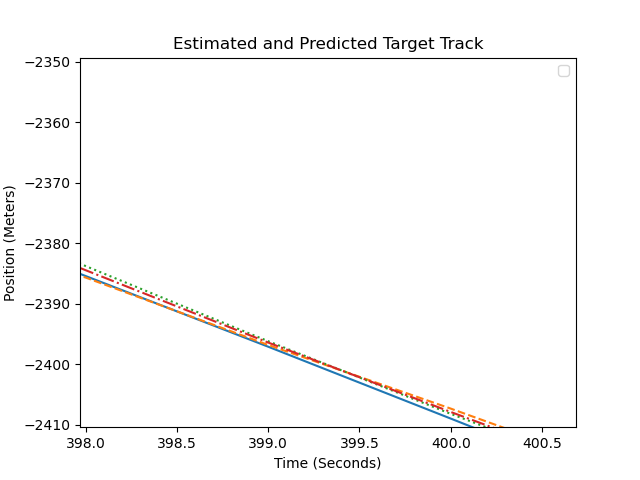

No handles with labels found to put in legend.


In [9]:
kl.plot_est_predTrack(x, z, xpred, xest)

<IPython.core.display.Javascript object>


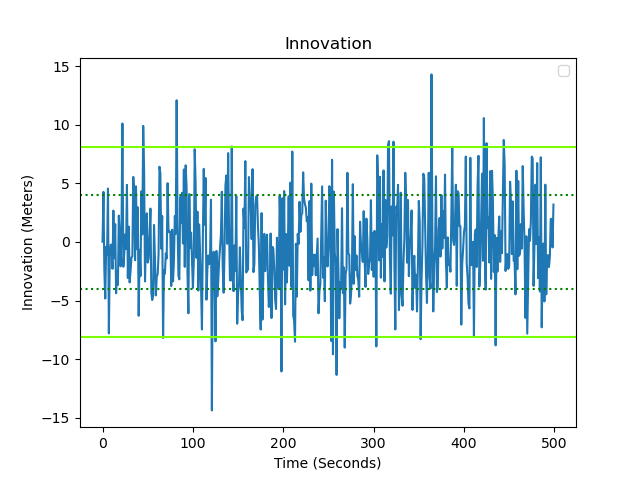

No handles with labels found to put in legend.


In [10]:
kl.plot_innov(xinnov)

<IPython.core.display.Javascript object>


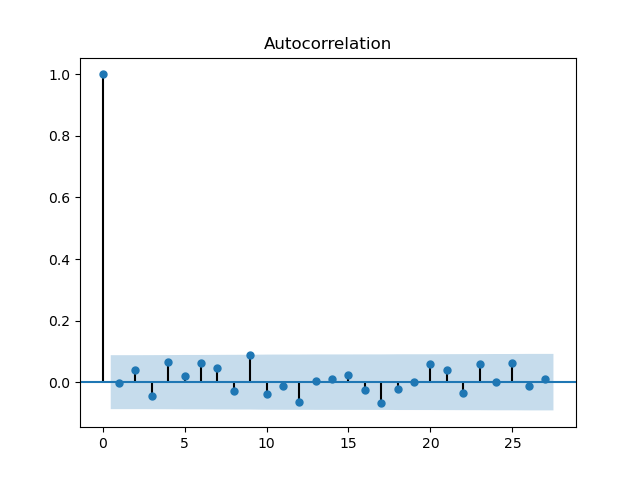

In [11]:
kl.plot_autocorr(xinnov)